In [46]:
#load and originze data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


#get all the target in data struct

df_2m = pd.read_csv(r"C:\UW-Madison\ECE539\Final Project\data\percent_change_2min.csv")
df_10m = pd.read_csv(r"C:\UW-Madison\ECE539\Final Project\data\percent_change_10min.csv")
df_30m = pd.read_csv(r"C:\UW-Madison\ECE539\Final Project\data\percent_change_30min.csv")
df_1hr = pd.read_csv(r"C:\UW-Madison\ECE539\Final Project\data\percent_change_1hr.csv")
#df_2hr = pd.read_csv(r"C:\UW-Madison\ECE539\Final Project\data\percent_change_2hr.csv")



y2 = df_2m.iloc[140+(6149-6121):].values.flatten()
y10 = df_10m.iloc[140+(6146-6121):].values.flatten()
y30 = df_30m.iloc[140+(6136-6121):].values.flatten()
y60 = df_1hr.iloc[140:].values.flatten()
#y120 = df_2hr.iloc[:].values.flatten()






#=====================>final targets<=================#
target = np.vstack([y2, y10, y30, y60]).T
print(target.shape)
#features = np.vstack([])

(2888823, 4)


In [47]:
#loading indicators

import os
import pandas as pd

left = [0,15,30,45,60,75,90,97,105,112,115,117,118,119,120]
right = [120,105,90,75,60,45,30,23,15,8,5,3,2,1,0]
folder_path = r"C:\UW-Madison\ECE539\Final Project\data\ind"
features_list = []
feature_dict = {}

scaler = MinMaxScaler()

for filename in os.listdir(folder_path):
    print(filename)
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read CSV
        df = pd.read_csv(file_path)


        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
   
        for numl, numr in zip(left, right):
            # Extract flattened values (adjust indexing as needed)
            
            feature_vector = df.iloc[20 + (6149 - 6121) + numl : -numr-1].values.flatten()


#            ---------->test<--------------
            if np.isnan(feature_vector).any():
                print("NaNs found in feature_vector!")
            
                arr = feature_vector  # ✅ Already a NumPy array, no need for `.values`
            
                nan_indices = np.where(np.isnan(arr))[0]  # Just one axis (1D vector)
            
                print("NaN found at indices:", nan_indices)
#      ----------------------------------------------------            
            # Append to feature list
            features_list.append(feature_vector)
    

# Stack into final feature matrix
import numpy as np
X = np.stack(features_list, axis=1)  # shape: (num_samples, num_files)

print("✅ Final X shape:", X.shape)


#try without ease of movement

adx.csv
bollinger_hband.csv
bollinger_hband_indicator.csv
bollinger_lband.csv
bollinger_lband_indicator.csv
bollinger_mavg.csv
bollinger_pband.csv
bollinger_wband.csv
cci.csv
dpo.csv
ema.csv
force_index.csv
KAMA.csv
macd.csv
negative_volume_index.csv
pvo_signal.csv
roc.csv
RSI.csv
ulcer_index.csv
ultimate_oscillator.csv
vwap.csv
✅ Final X shape: (2888823, 315)


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#make the Model 


#overall model
class StockMovementMLP(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 315
        hidden_dims = [1024, 512, 64, 32]  # try a different one [256,512,64,32]
        layers = []

        dims = [input_dim] + hidden_dims
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            #--------------------------#
            layers.append(nn.Dropout(0.2))  # Regularization make another model without this and see how it does
            #==========================#
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], 4)  # one output per time horizon

        self._init_weights() # initialize weights here

        #initialize weights 
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # He init
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x)  # [batch_size, 7]


In [49]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np




def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
        for X_batch, y_batch in batch_iterator:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        y_true_all = []
        y_pred_all = []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model(X_val)
                val_loss += criterion(val_pred, y_val).item()
                y_true_all.append(y_val.cpu())
                y_pred_all.append(val_pred.cpu())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Concatenate predictions and targets
        y_true_all = torch.cat(y_true_all).numpy()
        y_pred_all = torch.cat(y_pred_all).numpy()
        
        # Compute R²
        try:
            val_r2 = r2_score(y_true_all, y_pred_all)
            np.savetxt("y_pred_all.csv", y_pred_all, delimiter=",")
            np.savetxt("y_true_all.csv", y_true_all, delimiter=",")
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | R²: {val_r2:.4f}")
        except Exception as e:
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | R²: Error calculating R² → {e}")
            np.savetxt("y_pred_all.csv", y_pred_all, delimiter=",")
            np.savetxt("y_true_all.csv", y_true_all, delimiter=",")


        # Save best model
        if epoch % 1 == 0:
            torch.save(model.state_dict(), rf"C:\UW-Madison\ECE539\Final Project\weights_checkpoint\checkpoint_epoch{epoch}.pth")

        # Print stats
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Plot losses
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

           
            

    print("Training finished.")






Epoch 01 | Train Loss: 0.0923 | Val Loss: 0.0975 | R²: 0.3054
Epoch 01 | Train Loss: 0.0923 | Val Loss: 0.0975


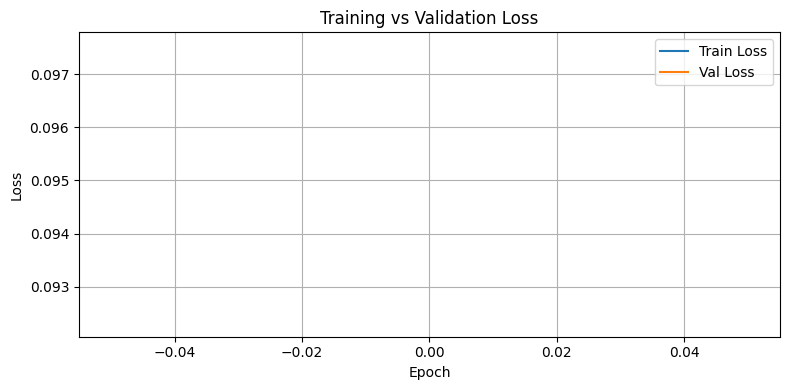

Epoch 02 | Train Loss: 0.0832 | Val Loss: 0.0767 | R²: 0.3395
Epoch 02 | Train Loss: 0.0832 | Val Loss: 0.0767


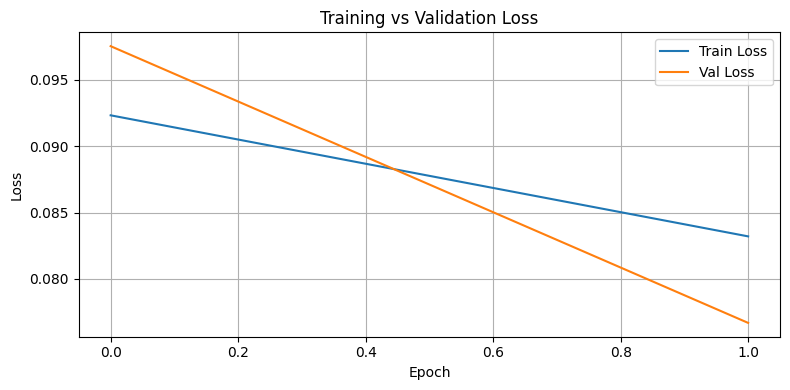

Epoch 03 | Train Loss: 0.0800 | Val Loss: 0.1055 | R²: 0.3075
Epoch 03 | Train Loss: 0.0800 | Val Loss: 0.1055


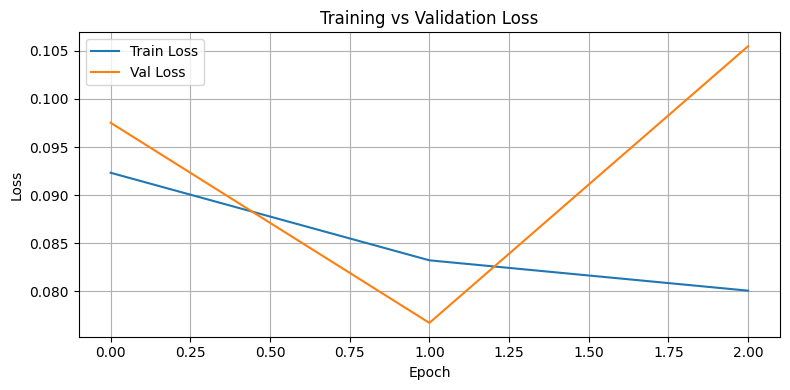

Epoch 04 | Train Loss: 0.0790 | Val Loss: 0.0970 | R²: 0.3230
Epoch 04 | Train Loss: 0.0790 | Val Loss: 0.0970


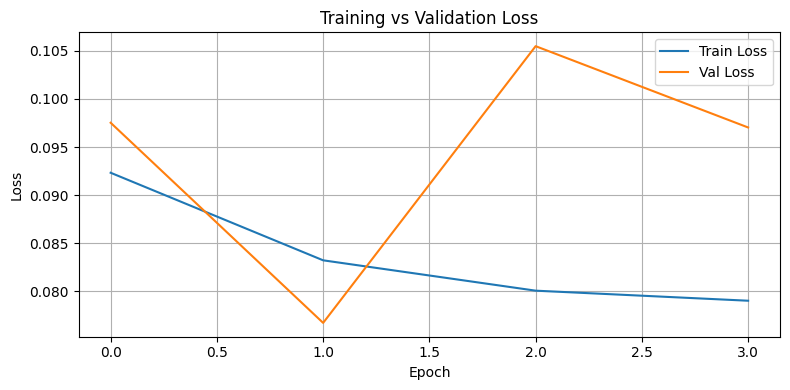

Epoch 05 | Train Loss: 0.0782 | Val Loss: 0.1070 | R²: 0.2927
Epoch 05 | Train Loss: 0.0782 | Val Loss: 0.1070


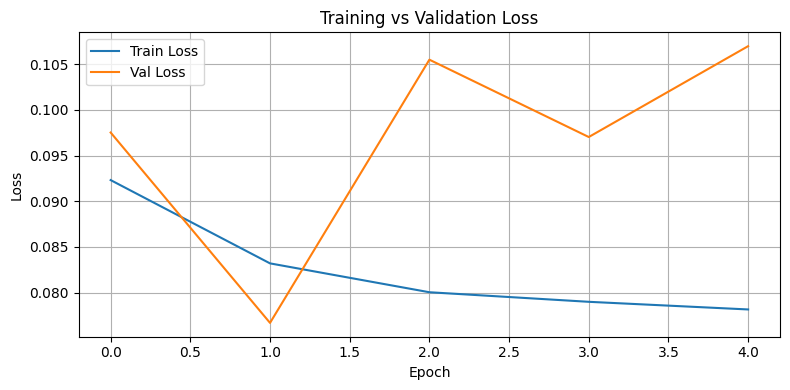

Training finished.


In [50]:
#run
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.float32)

# Split into train and validation (e.g., 80/20)
num_samples = X.shape[0]
split = int(num_samples * 0.95)

X_train, X_val = X_tensor[:split], X_tensor[split:]
y_train, y_val = y_tensor[:split], y_tensor[split:]

# Create Datasets and Loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

My_model = StockMovementMLP()

train_model(My_model, train_loader, val_loader, num_epochs=5, lr=1e-3)
